In [8]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [24]:
text = open('1661-0.txt', encoding='utf-8').read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [25]:
character = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(character))
indices_char = dict((i, c) for i, c in enumerate(character))

print(f'unique chars: {len(character)}')

unique chars: 73


In [26]:
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len ])
    next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [27]:
X = np.zeros((len(sentences), seq_len, len(character)), dtype=bool) # Use the built-in bool
y = np.zeros((len(sentences), len(character)), dtype=bool) # Use the built-in bool
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

sentences[124]
next_chars[100]

'e'

In [28]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [29]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [31]:
X.shape

(193950, 40, 73)

In [32]:
y.shape

(193950, 73)

In [33]:
model = Sequential()
model.add(LSTM(500, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 500)               1148000   
                                                                 
 dense_1 (Dense)             (None, 73)                36573     
                                                                 
 activation_1 (Activation)   (None, 73)                0         
                                                                 
Total params: 1184573 (4.52 MB)
Trainable params: 1184573 (4.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y,
                    validation_split=0.01,
                    batch_size=128,
                    epochs=2,
                    shuffle=True).history

Epoch 1/2
1501/1501 [==============================] - 609s 405ms/step - loss: 2.1807 - accuracy: 0.3701 - val_loss: 2.3311 - val_accuracy: 0.3510
Epoch 2/2
1501/1501 [==============================] - 591s 394ms/step - loss: 1.7182 - accuracy: 0.4845 - val_loss: 2.0798 - val_accuracy: 0.4278


In [36]:
loss_and_acc=model.evaluate(X,y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

6061/6061 [==============================] - 932s 154ms/step - loss: 1.6575 - accuracy: 0.5023
Test Loss 1.6574660539627075
Test Accuracy 0.5023098587989807


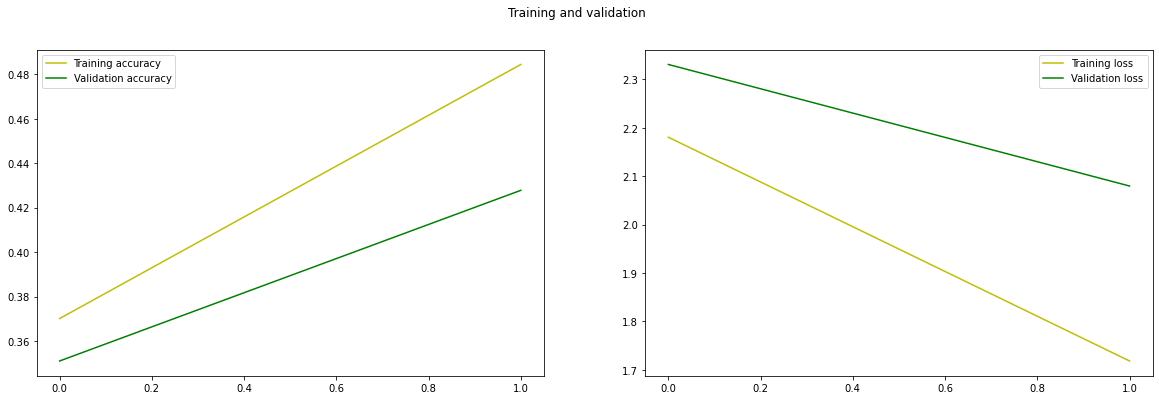

In [37]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'g', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'g', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

In [38]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
    return x

prepare_input("This is an example of input of our model".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [39]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [40]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char

        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [41]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [42]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [43]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'any ', 'my ', 'his ', 'somementration ']

that which does not kill us makes us str
['eet ', 'ang ', 'ong ', 'icked ', 'uck ']

i'm not upset that you lied to me, i'm u
['s ', 'nder ', 'pon ', 'ld ', 'bon ']

and those who were seen dancing were tho
['ught ', 'se ', 'me ', 'ok ', ' go ']

it is hard enough to remember my opinion
[' of ', ', ', '. ', 'al ', 'ed ']

